# AXA Data Challenge Report notebook
## Group: Yellow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Some constants

In [2]:
alpha = 0.1

In [3]:
date = 'DATE'
ass = 'ASS_ASSIGNMENT'
target = 'CSPL_RECEIVED_CALLS'

In [4]:
day_off_2011 = ['2011-01-01','2011-04-24','2011-04-25','2011-05-01','2011-05-08',
                '2011-06-02','2011-06-12','2011-06-13','2011-07-14','2011-08-15',
                '2011-11-01','2011-11-11','2011-12-25']
day_off_2012 = ['2012-01-01','2012-04-08','2012-04-09','2012-05-01','2012-05-08',
                '2012-05-17','2012-05-27','2012-05-28','2012-07-14','2012-08-15',
                '2012-11-01','2012-11-11','2012-12-25']
day_off_2013 = ['2013-01-01','2013-03-31','2013-04-01','2013-05-01','2013-05-08',
                '2013-05-09','2013-05-19','2013-05-20','2013-07-14','2013-08-15',
                '2013-11-01','2013-11-11','2013-12-25']
day_off_all = day_off_2011 + day_off_2012 + day_off_2013
day_off_date = [pd.to_datetime(x).date() for x in day_off_all]

In [9]:
def lin_ex(y, y_hat):
    return np.average(np.exp(alpha * (y - y_hat)) - alpha * (y - y_hat) - 1)

### Read data

In [7]:
%%time
df = pd.read_csv('../../train_2011_2012_2013.csv',sep=';')

<string>:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 2min 52s, sys: 33.4 s, total: 3min 25s
Wall time: 3min 55s


In [8]:
df = df[(df[ass] != 'Evenements') & (df[ass] != 'Gestion Amex')]

In [10]:
df[date] = pd.to_datetime(df[date])
df[ass] = df[ass].astype('category')
df.shape

(10864301, 86)

In [11]:
df[[ass,date,target]][df[target]>20].loc[(df[ass]=='Téléphonie') & (df[date]==pd.to_datetime('2013-11-18 11:30:00') )]

,ASS_ASSIGNMENT,DATE,CSPL_RECEIVED_CALLS
9696073,Téléphonie,2013-11-18 11:30:00,53
9696307,Téléphonie,2013-11-18 11:30:00,72
9696347,Téléphonie,2013-11-18 11:30:00,24
9696369,Téléphonie,2013-11-18 11:30:00,28
9696372,Téléphonie,2013-11-18 11:30:00,53
9696375,Téléphonie,2013-11-18 11:30:00,33
9696392,Téléphonie,2013-11-18 11:30:00,24
9696404,Téléphonie,2013-11-18 11:30:00,135
9696415,Téléphonie,2013-11-18 11:30:00,26
9696441,Téléphonie,2013-11-18 11:30:00,40


### Remark

There are duplicated lines of the same ASS_ASSIGNMENT and DATE. We need to do a groupby and sum them up.

In [12]:
df_useful = df[[date,ass,target]].groupby([date, ass])[target].aggregate(np.sum)
df_useful = df_useful.reset_index()
df_useful.shape

(1016660, 3)

In [13]:
def get_slot(timestamp):
    """get the time slot of the day (0 for 00:00, 1 for 00:30, ... 47 for 23:30)"""
    return 2 * timestamp.hour + (timestamp.minute == 30)

### Some reasonable feature candidates could be
- time slot
- ASS_ASSIGNMENT
- weekday
- month
- year

In [14]:
%%time
feature_df = df_useful.copy()
feature_df['slot'] = feature_df.DATE.apply(get_slot)
feature_df['dayofweek'] = feature_df.DATE.apply(lambda x: x.dayofweek).astype('category')
feature_df['month'] = feature_df.DATE.apply(lambda x: x.month).astype('category')
feature_df['year'] = feature_df.DATE.apply(lambda x: x.year).astype('category')

CPU times: user 16.5 s, sys: 619 ms, total: 17.1 s
Wall time: 17.4 s


#### And other useful features might be 
- whether it's a day off or not
- whether it's a day after day off

In [15]:
def is_day_off(timestamp):
    return timestamp.date() in day_off_date

def is_day_after_day_off(timestamp):
    return (timestamp + pd.DateOffset(-1)).date() in day_off_date

In [16]:
%%time
feature_df['day_off'] = feature_df.DATE.apply(is_day_off)
feature_df['day_after_day_off'] = feature_df.DATE.apply(is_day_after_day_off)

CPU times: user 30.5 s, sys: 549 ms, total: 31.1 s
Wall time: 31.7 s


In [17]:
feature_df.head()

,DATE,ASS_ASSIGNMENT,CSPL_RECEIVED_CALLS,slot,dayofweek,month,year,day_off,day_after_day_off
0,2011-01-01,Crises,0,0,5,1,2011,True,False
1,2011-01-01,Domicile,0,0,5,1,2011,True,False
2,2011-01-01,Gestion,0,0,5,1,2011,True,False
3,2011-01-01,Gestion - Accueil Telephonique,0,0,5,1,2011,True,False
4,2011-01-01,Gestion Assurances,0,0,5,1,2011,True,False


In [18]:
X_df = pd.get_dummies(feature_df[[ass, 'slot', 'dayofweek', 'month', 'year', 'day_off', 'day_after_day_off']])

In [19]:
X_df = X_df.reindex_axis(sorted(X_df.columns), axis=1)

In [20]:
X_df = X_df.as_matrix()
y_df = feature_df[target].as_matrix()

In [21]:
X_df.shape

(1016660, 51)

# Data visualization and preliminary analysis

In [22]:
ass_unique = sorted(feature_df[ass].unique())
month_unique = sorted(feature_df['month'].unique())
day_unique = sorted(feature_df['dayofweek'].unique())

## Average number of calls for each time slot

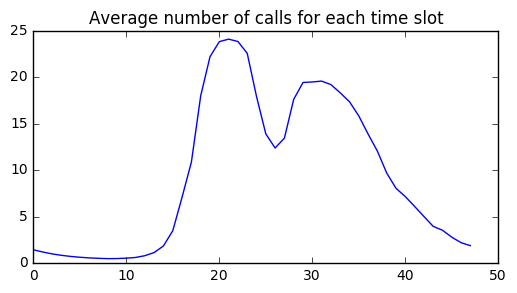

In [23]:
plt.figure(figsize=(6,3))
plt.plot(feature_df.groupby('slot')[target].agg('mean'))
plt.title('Average number of calls for each time slot');

#### Observation:
We have two peaks at around 10:00-11:00 and 14:30-15:30

## Impact of ASS_ASSIGNMENT
We draw the average number of calls w.r.t. time slot for each ASS_ASSIGNMENT.

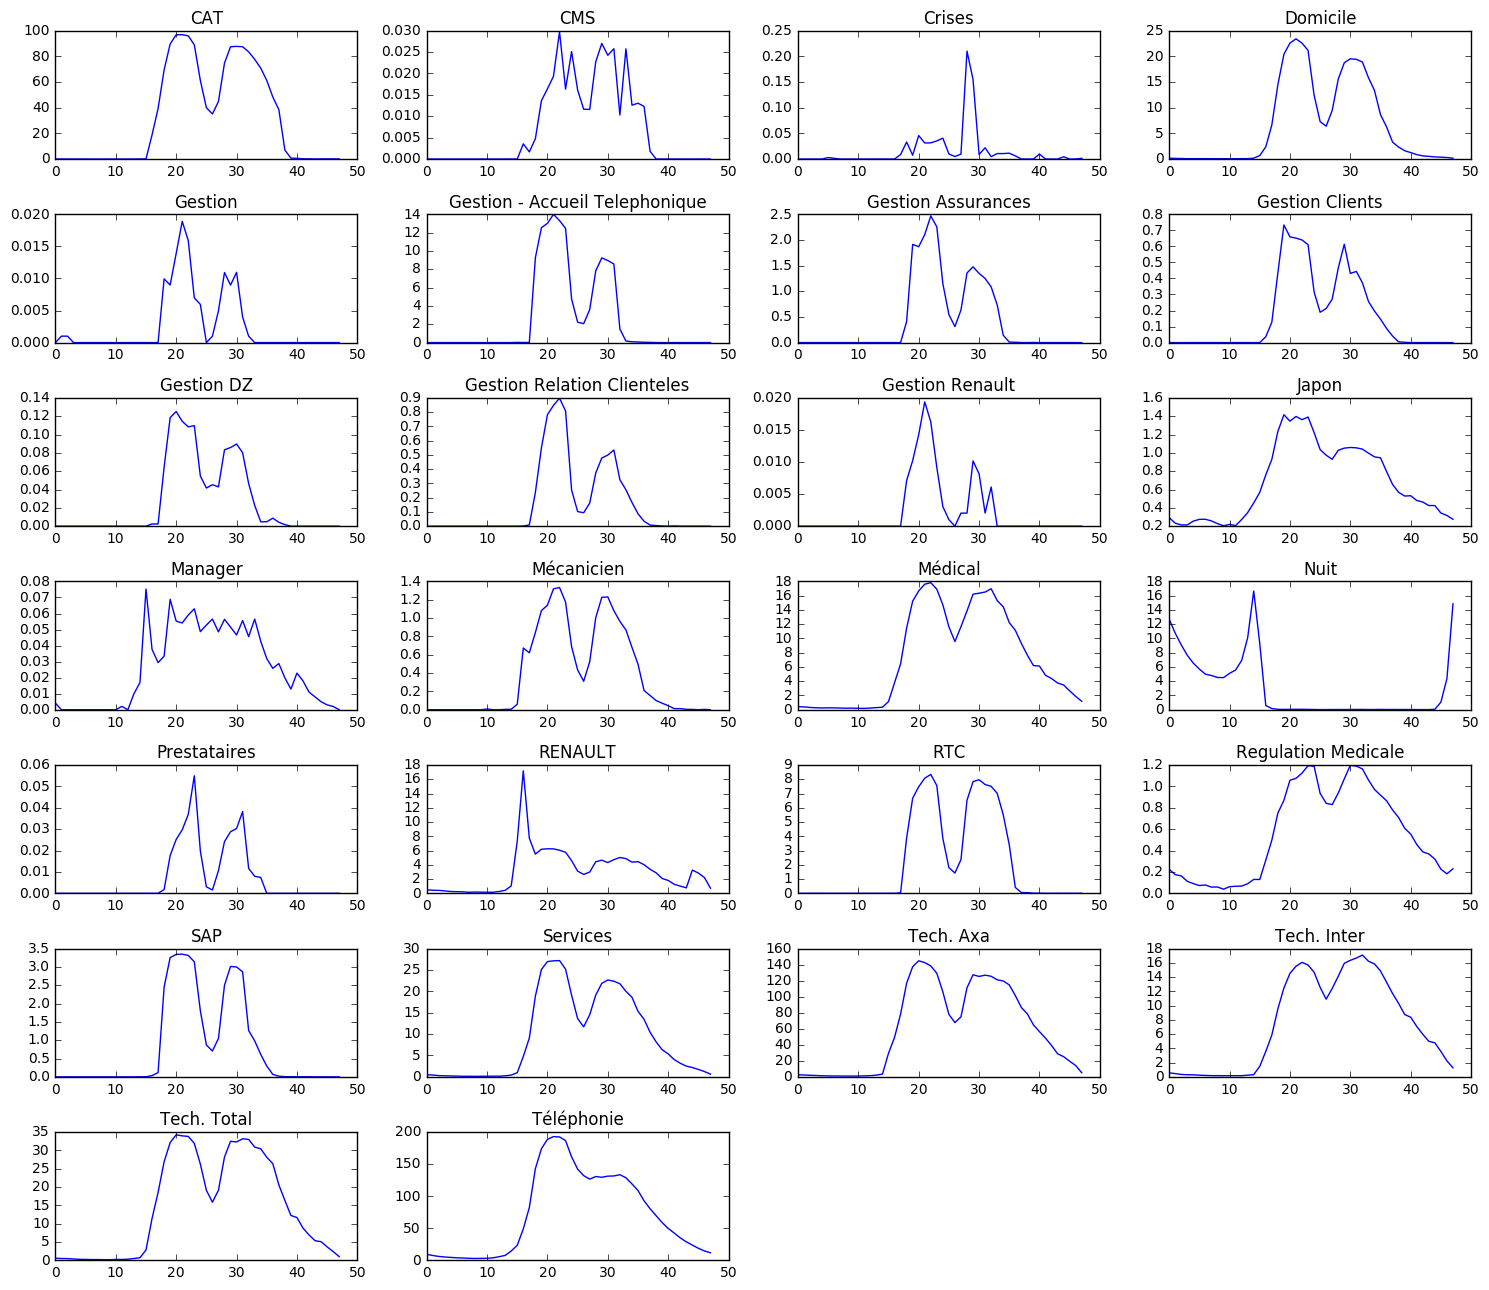

In [26]:
plt.figure(figsize=(15,13))
for i, a in enumerate(ass_unique):
    plt.subplot(7, 4, i+1)
    plt.plot(feature_df[feature_df.ASS_ASSIGNMENT == a].groupby('slot')[target].agg('mean'))
    plt.title(a)
plt.tight_layout()

#### Observation:
- The curves are indeed quite different for different ASS_ASSIGNMENT, which means that ASS_ASSIGNMENT is an important feature;
- Most of them have two peaks just as the average curve. But there are some exceptions, e.g. Nuit.

## Impact of year
We draw the average number of calls w.r.t. time slot for each year.

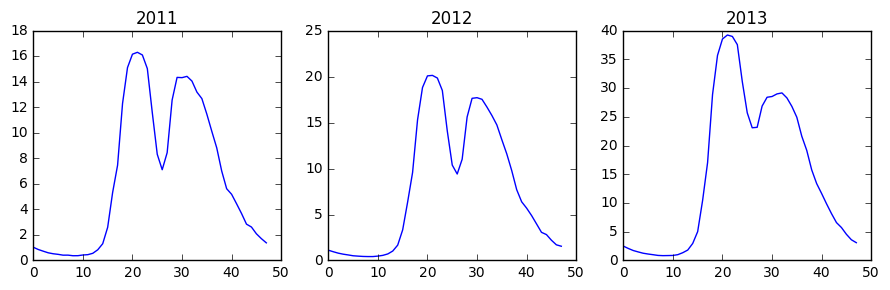

In [27]:
plt.figure(figsize=(9,3))
for i, year in enumerate([2011,2012,2013]):
    plt.subplot(1, 3, i+1)
    plt.plot(feature_df[feature_df['year'] == year].groupby('slot')[target].agg('mean'))
    plt.title(year)
plt.tight_layout()
plt.show()

#### Observation:
- Average number of calls in increasing order: 2011 < 2012 < 2013

## Impact of month
We draw the average number of calls w.r.t. time slot for each month.

1 for January and 12 for December

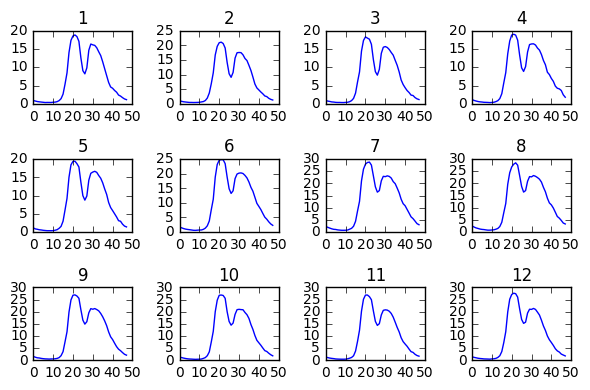

In [22]:
for i, mon in enumerate(month_unique):
    plt.subplot(3, 4, i+1)
    plt.plot(feature_df[feature_df['month'] == mon].groupby('slot')[target].agg('mean'))
    plt.title(mon)
plt.tight_layout()
plt.show()

#### Observation:
- The feature 'month' doesn't have much impact on the profile of the curves;
- But we notice that we tend to have more calls in the summer and less calls in the winter.

## Impact of weekday
We draw the average number of calls w.r.t. time slot for each weekday.

0 for Monday and 6 for Sunday

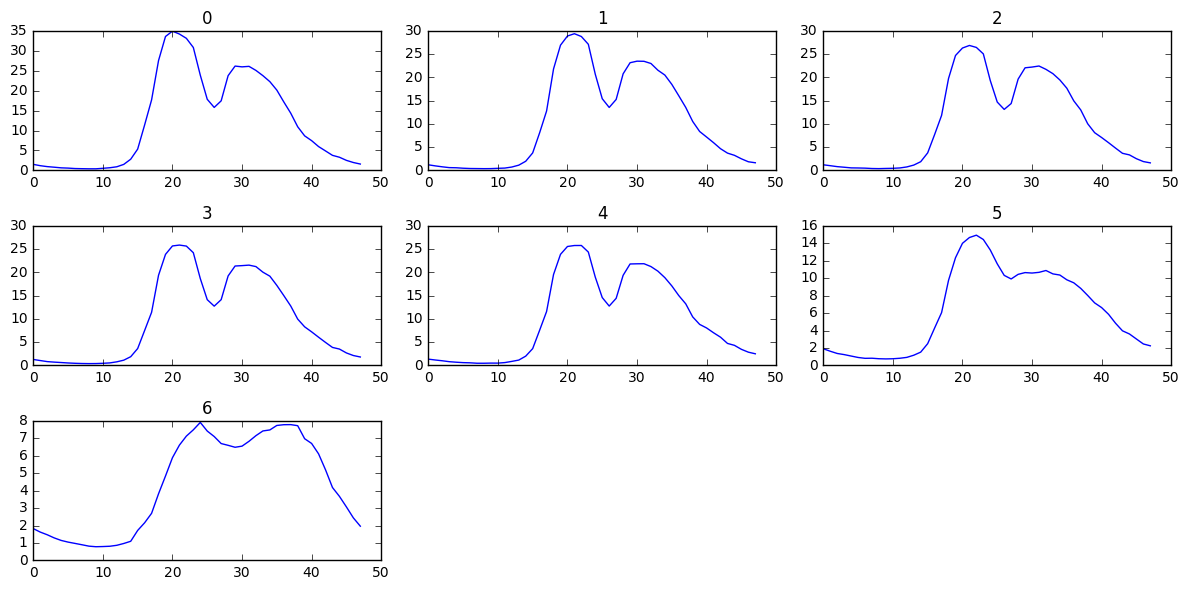

In [29]:
plt.figure(figsize=(12,6))
for i, weekday in enumerate(day_unique):
    plt.subplot(3, 3, i+1)
    plt.plot(feature_df[feature_df['dayofweek'] == weekday].groupby('slot')[target].agg('mean'))
    plt.title(weekday)
plt.tight_layout()
plt.show()

#### Observation:
- There are much fewer calls during the weekend than during the week;
- We tend to have more calls on Monday than the other weekdays.

## Impact of day_off
We draw the average number of calls w.r.t. time slot depending on whether the day is a day off or not.

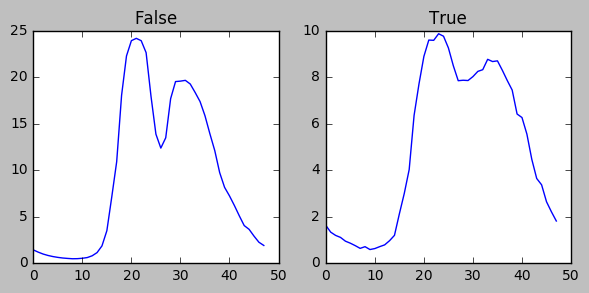

In [302]:
plt.figure(figsize=(6,3))
for i, istrue in enumerate([False,True]):
    plt.subplot(1, 2, i+1)
    plt.plot(feature_df[feature_df['day_off'] == istrue].groupby('slot')[target].agg('mean'))
    plt.title(istrue)
plt.tight_layout()
plt.show()

#### Observation:
- There are fewer calls on a day off

## Impact of day_after_day_off
We draw the average number of calls w.r.t. time slot depending on if the day is a day after a day off.

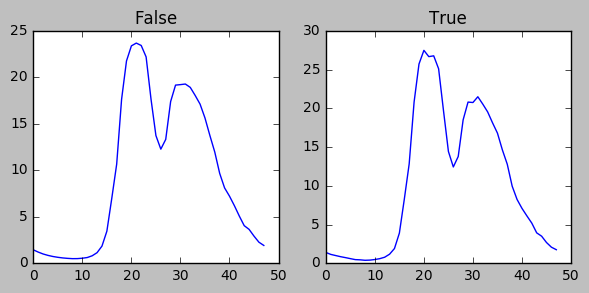

In [303]:
plt.figure(figsize=(6,3))
for i, istrue in enumerate([False,True]):
    plt.subplot(1, 2, i+1)
    plt.plot(feature_df[feature_df['day_after_day_off'] == istrue].groupby('slot')[target].agg('mean'))
    plt.title(istrue)
plt.tight_layout()
plt.show()

#### Observation:
- We tend to get a bit more calls when it's a day after a day off.

In [268]:
pd.to_datetime('2013-11-01').date() in day_off_date

True

In [22]:
day_off.date()

datetime.date(2011, 1, 6)

# 1st approach

# 3rd approach - Random Forest

In [167]:
from sklearn.model_selection import ShuffleSplit

skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=23)
skf_is = list(skf.split(X_df))[0]
train_is, test_is = skf_is

X_train_df = X_df[train_is].copy()                                  
y_train_df = y_df[train_is].copy()
X_test_df = X_df[test_is].copy()                                    
y_test_df = y_df[test_is].copy()

skf2 = ShuffleSplit(n_splits=2, test_size=0.2, random_state=25)
skf_is2 = list(skf2.split(X_df))[0]
train_is2, test_is2 = skf_is2

X_train_df2 = X_df[train_is2].copy()                                  
y_train_df2 = y_df[train_is2].copy()
X_test_df2 = X_df[test_is2].copy()                                    
y_test_df2 = y_df[test_is2].copy() 

In [298]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(max_leaf_nodes=200, n_estimators=10, min_samples_leaf=10, n_jobs=-1, oob_score=True, random_state=42, warm_start=True)
rf2 = RandomForestRegressor(max_leaf_nodes=200, n_estimators=10, min_samples_leaf=10, n_jobs=-1, oob_score=True, random_state=57, warm_start=True)

In [299]:
%%time
rf1.fit(X_train_df, y_train_df)

Wall time: 41.6 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=True)

In [300]:
%%time
rf2.fit(X_train_df2, y_train_df2)

Wall time: 41.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=True, random_state=57,
           verbose=0, warm_start=True)

In [303]:
C = 2.4
y_pred_df = C * rf1.predict(X_test_df)
y_pred_df2 = C * rf2.predict(X_test_df2)
error = lin_ex(y_test_df, y_pred_df)
error2 = lin_ex(y_test_df2, y_pred_df2)
print error
print error2

1.22786663092
1.52512468399


In [278]:
rf = RandomForestRegressor(max_features=0.8, max_leaf_nodes=100, 
                           n_estimators=500, min_samples_leaf=50, 
                           n_jobs=-1, oob_score=True, random_state=42, warm_start=True)

In [279]:
%%time
rf.fit(X_df, y_df)

Wall time: 10min 47s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.8, max_leaf_nodes=100, min_impurity_split=1e-07,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=True)

In [109]:
sub = pd.read_csv('../data/submission.txt', sep='\t')

In [111]:
sub.DATE = pd.to_datetime(sub.DATE)

### Submission

In [112]:
sub[date] = pd.to_datetime(sub[date])
sub[ass] = sub[ass].astype('category')

In [113]:
sub['slot'] = sub.DATE.apply(get_slot)
sub['dayofweek'] = sub.DATE.apply(lambda x: x.dayofweek).astype('category')
sub['month'] = sub.DATE.apply(lambda x: x.month).astype('category')
sub['year'] = sub.DATE.apply(lambda x: x.year).astype('category')
sub['day_off'] = sub.DATE.apply(is_day_off)
sub['day_after_day_off'] = sub.DATE.apply(is_day_after_day_off)
sub['year_2011'] = 0

In [114]:
sub['year_2011'] = sub['year_2011'].astype('float')

In [115]:
X_sub_df = pd.get_dummies(sub[[ass, 'slot', 'dayofweek', 'month', 'year', 'day_off', 'day_after_day_off', 'year_2011']])

In [116]:
X_sub_df = X_sub_df.reindex_axis(sorted(X_sub_df.columns), axis=1)

In [124]:
X_sub_df.shape

(82909, 51)

In [280]:
sub['prediction'] = C * rf.predict(X_sub_df)

In [281]:
sub.head()

,DATE,ASS_ASSIGNMENT,prediction,slot,dayofweek,month,year,day_off,day_after_day_off,year_2011
0,2012-12-28,CMS,2.161581,0,4,12,2012,False,False,0.0
1,2012-12-28,Crises,2.161581,0,4,12,2012,False,False,0.0
2,2012-12-28,Domicile,2.836536,0,4,12,2012,False,False,0.0
3,2012-12-28,Gestion,2.150564,0,4,12,2012,False,False,0.0
4,2012-12-28,Gestion - Accueil Telephonique,2.161581,0,4,12,2012,False,False,0.0


In [282]:
real_sub = sub.iloc[:, :3]

In [283]:
real_sub.head()

,DATE,ASS_ASSIGNMENT,prediction
0,2012-12-28,CMS,2.161581
1,2012-12-28,Crises,2.161581
2,2012-12-28,Domicile,2.836536
3,2012-12-28,Gestion,2.150564
4,2012-12-28,Gestion - Accueil Telephonique,2.161581


In [286]:
real_sub.DATE = real_sub.DATE.astype(str) + ".000"

In [287]:
real_sub.to_csv('../data/sub_chiaman_5.txt', sep='\t', index=None)